In [1]:
import numpy as np
import pandas as pd

## Problem taken to solve as an example

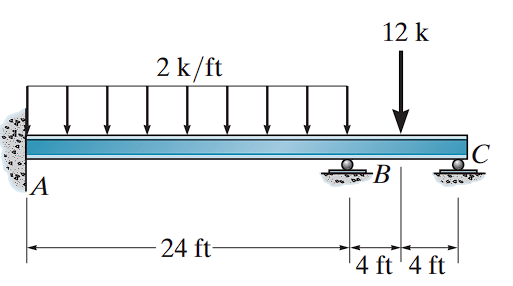

In [2]:
from PIL import Image
from IPython.display import display
img = Image.open('prob.png')
display(img)

## Nodes in a beam

The nodes in a beam would be a 1-D array since we are dealing with beams, spanning in only one direction. This array will only contain the x-coordintes of the nodes.

In [3]:
nodes = np.array([0, 288, 384])

## Elements of the continuos beam

Elements of the continuous beam are comprised of individual members which are represented by a 2-D array. Each entry in the 2-D array gives information about the particular member. The information comprises of the nodes that have a member between them. They occupy the 1st and 2nd position in the information array. The next 2 elements are E (Modulus of elasticity) and I (Moment of Inertia).

In [4]:
elements = np.array([[1, 2, 29000, 510], [2, 3, 29000, 510]])

## Member forces

Member forces are going to be represented by a 2-D array in which each element provides information about the nodes in between which the load is applied, the type of load, the distance of application of load from the 1st node and the magnitude of load.

## Types of loads supported

Concentrated load at a distance "a" from the 1st node, Uniformly distributed load emerging at the first node and ending at a 2nd node and combination of both of these loads

In [5]:
member_loads = np.array([[1, 2, 2, 0, 0.167], [2, 3, 1, 48, 12]], dtype = float)

## Fixed End Moments Calculator

Takes in the type of load and the variable a as defined in "Types of loads supported" and the length of the member and gives an 1-D array as a result, containing data in the order -> Fixed End Shear at node 1, Fixed End Moment at node 1, Fixed End Shear at node 2, Fixed End Moment at node 2.

In [6]:
def fixed_end_calc(typ, a, L, W):
    if typ == 1:
        b = L - a
        FMa = ((W * (b ** 2) * a) / (L ** 2))
        FMb = -((W * (a ** 2) * b) / (L ** 2))
        FSb = ((W * a) / L) * (((b / (L ** 2)) * (a - b)) + 1)
        FSa = W - FSb
        return np.array([FSa, FMa, FSb, FMb])
    else:
        FMa = (W * (L ** 2)) / 12
        FMb = -((W * (L ** 2)) / 12)
        FSa = (W * L) / 2
        FSb = (W * L) / 2
        return np.array([FSa, FMa, FSb, FMb])

## Transform row

Transforming the row of the global stiffness matrix to get all the known forces first and the unknown forces

In [7]:
def transform_row(stiffness, forces, num_nodes):
    ns = []
    order_f = []
    for key in forces.keys():
        order_f.append(key)
        ns.append(stiffness[key - 1])
    for i in range(num_nodes):
        if i + 1 not in forces.keys():
            order_f.append(i + 1)
            ns.append(stiffness[i])
    ns = np.array(ns)
    order_f = np.array(order_f)
    return ns, order_f

## Transform column

Transforming the columns of the global stiffness matrix to get all the unknown displacements first and then the known displacements

In [8]:
def transform_col(stiffness, boundary_conditions, num_nodes):
    ns = [[] for i in range(num_nodes)]
    order_d = []
    for i in range(num_nodes):
        if i + 1 not in boundary_conditions.keys():
            order_d.append(i + 1)
            t1 = stiffness[:, i]
            for j in range(num_nodes):
                ns[j].append(t1[j])
    for i in range(num_nodes):
        if i + 1 in boundary_conditions.keys():
            order_d.append(i + 1)
            t1 = stiffness[:, i]
            for j in range(num_nodes):
                ns[j].append(t1[j])
    ns = np.array(ns)
    order_d = np.array(order_d)
    return ns, order_d

## Partitions

Partitioning the global stiffness matrix into 4 matrices that correspond to unknown displacement-known force, unknown displacement-unknown force, known displacement-known force, unknown displacement-unknown force

In [9]:
def partitions(stiff, fn, num):
    S1 = []
    for i in range(fn):
        temp = stiff[i, 0: fn]
        S1.append(temp)
    S2 = []
    for i in range(fn):
        temp = stiff[i, fn: num]
        S2.append(temp)
    S3 = []
    for i in range(fn, num):
        temp = stiff[i, 0: fn]
        S3.append(temp)
    S4 = []
    for i in range(fn, num):
        temp = stiff[i, fn: num]
        S4.append(temp)

    S1 = np.array(S1)
    S2 = np.array(S2)
    S3 = np.array(S3)
    S4 = np.array(S4)
    return S1, S2, S3, S4

## Member End Forces

It is set with the keys as the degrees of freedom and values as the loads

In [10]:
end_loads = {4 : 0, 6 : 0}

## Boundary Conditions

This is represented as a set with keys as the degree of freedom and value as the displacement. Each node has 2 degrees of freedom. The 1st is the displacement degree of freedom and the second is the rotation degree of freedom.

In [11]:
boundary_conditions = {1 : 0, 2 : 0, 3 : 0, 5 : 0}

In [12]:
num_nodes = len(nodes)
global_stiff = np.zeros((2 * num_nodes, 2 * num_nodes))

In [13]:
for element in elements:
    n1 = element[0]
    n2 = element[1]
    E = element[2]
    I = element[3]
    L = abs(nodes[n2 - 1] - nodes[n1 - 1])
    a = 12 / (L ** 3)
    b = 6 / (L ** 2)
    c = 4 / L
    d = 2 / L
    member_stiff = np.array([[a, b, -a, b],
                             [b, c, -b, d],
                             [-a, -b, a, -b],
                             [b, d, -b, c]])
    member_stiff = member_stiff * (E * I)
    l1 = 2 * n1 - 1
    l2 = 2 * n1
    l3 = 2 * n2 - 1
    l4 = 2 * n2
    indexes = [l1, l2, l3, l4]
    for i in range(4):
        for j in range(4):
            global_stiff[indexes[i] - 1][indexes[j] - 1] += member_stiff[i][j]

In [14]:
fixed_end = np.zeros(2*num_nodes)

In [15]:
for loading in member_loads:
    n1 = int(loading[0])
    n2 = int(loading[1])
    L = abs(nodes[n2 - 1] - nodes[n1 - 1])
    typ = loading[2]
    dis = loading[3]
    W = loading[4]
    fem = fixed_end_calc(typ, dis, L, W)
    fixed_end[2*n1 - 2] += fem[0]
    fixed_end[2*n1 - 1] += fem[1]
    fixed_end[2*n2 - 2] += fem[2]
    fixed_end[2*n2 - 1] += fem[3]

In [16]:
num_nodes = len(nodes)
global_stiff, new_f_order = transform_row(global_stiff, end_loads, 2*num_nodes)
global_stiff, new_d_order = transform_col(global_stiff, boundary_conditions, 2*num_nodes)
S1, S2, S3, S4 = partitions(global_stiff, len(end_loads), 2*num_nodes)

In [17]:
known = [[boundary_conditions[key]] for key in boundary_conditions.keys()]
known = np.array(known)

In [18]:
known_forces = []
known_fem = []
for key in end_loads.keys():
    known_forces.append([end_loads[key]])
    known_fem.append(fixed_end[key - 1])
known_forces = np.array(known_forces)
known_fem = np.array(known_fem)

## Multiplier function

Multiplies two matrices and returns a matrix

In [19]:
def mul(A, B):
    result = np.zeros((A.shape[0], B.shape[1]))
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            result[i][j] = (A[i, :] * B[:, j]).sum()
    return result

In [20]:
prod = mul(S2, known)

In [21]:
for i in range(len(known_forces)):
    known_forces[i][0] -= prod[i][0]

In [22]:
for i in range(len(known_fem)):
    known_forces[i][0] -= known_fem[i]

In [23]:
known_forces = [force[0] for force in known_forces]

In [24]:
unknown_disp = np.linalg.solve(S1, known_forces)

In [25]:
ud = []
for i in range(len(unknown_disp)):
    ud.append([unknown_disp[i]])
ud = np.array(ud)
ans1 = mul(S3, ud)
ans2 = mul(S4, known)
unknown_forces = []
for i in range(len(ans1)):
    unknown_forces.append([ans1[i][0] + ans2[i][0]])

In [26]:
u_disp, u_force, order_disp, order_force = unknown_disp, unknown_forces, new_d_order, new_f_order
complete_forces = {}
complete_disps = {}
for key in boundary_conditions.keys():
    complete_disps[key] = boundary_conditions[key]
for key in end_loads.keys():
    complete_forces[key] = end_loads[key]
known_disp_index_len = len(boundary_conditions)
known_forces_index_len = len(end_loads)
for i in range(2*len(nodes) - known_disp_index_len):
    complete_disps[order_disp[i]] = u_disp[i]
for i in range(known_forces_index_len, 2*len(nodes)):
    complete_forces[order_force[i]] = u_force[i - known_forces_index_len][0]

In [27]:
for key in complete_forces.keys():
    if key not in end_loads:
        complete_forces[key] += fixed_end[key - 1]

## Visualising the beam and the complete displacements

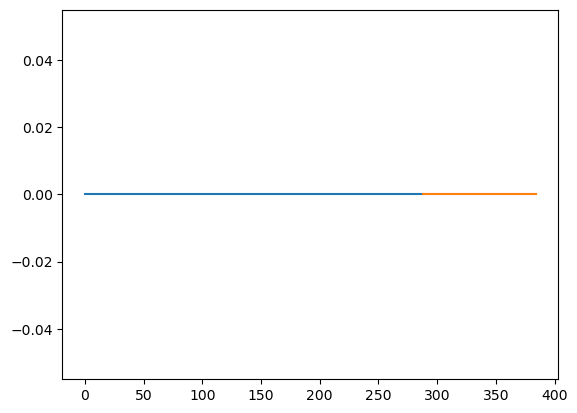

In [28]:
import matplotlib.pyplot as plt
for element in elements:
    n1 = element[0]
    n2 = element[1]
    x1 = nodes[n1 - 1]
    x2 = nodes[n2 - 1]
    y1 = 0
    y2 = 0
    x = [x1, x2]
    y = [y1, y2]
    plt.plot(x, y)
plt.show()

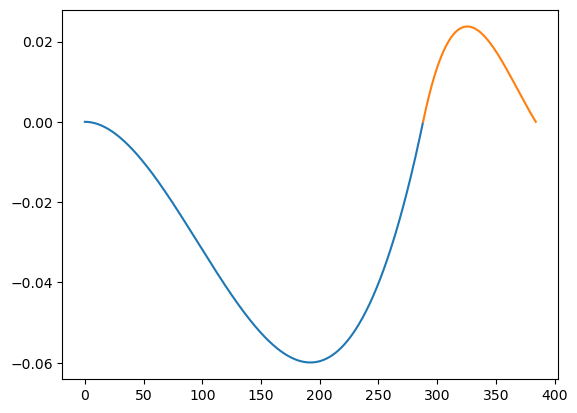

In [29]:
prev_x = 0
for element in elements:
    n1 = element[0]
    n2 = element[1]
    x1 = nodes[n1 - 1]
    x2 = nodes[n2 - 1]
    u1, u2, u3, u4 = complete_disps[2*n1 - 1], complete_disps[2*n1], complete_disps[2*n2 - 1], complete_disps[2*n2]
    x = np.arange(x1, x2 + 0.5, 0.5)
    x_calc = x - prev_x
    L = abs(nodes[n2 - 1] - nodes[n1 - 1])
    N1 = 1 - 3 * ((x_calc / L) ** 2) + 2 * ((x_calc / L) ** 3)
    N2 = x_calc * ((1 - x_calc / L) ** 2)
    N3 = 3 * ((x_calc / L) ** 2) - 2 * ((x_calc / L) ** 3)
    N4 = ((x_calc ** 2) / L) * (-1 + x_calc / L)
    y = N1*u1 + N2*u2 + N3*u3 + N4*u4
    prev_x = x2
    plt.plot(x, y)
plt.show()